In [1]:
%matplotlib inline

import os, sys, glob, scipy, warnings
import scipy.stats as ss
from scipy.stats import pearsonr,spearmanr
from scipy.spatial.distance import squareform
import matplotlib, scipy
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.stats import one_sample_permutation, two_sample_permutation, correlation_permutation
from nltools.stats import threshold
from nltools.mask import expand_mask, collapse_mask
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
topdir="/media/haiyanwu/HDD2/xinyi_RanDishonesty/"
behav_dir=topdir+'behav_ddm/'
fmri_dir=topdir+"dishonesty_fMRI/"



In [4]:
#subList=[104,105,124]
subList=[104,105,108,109,110,111,112,113,114,115,117,120,121,122,124,125,126,127,130,131,133,134,135,137,138,139,140]#27
subNums = subList
subIndices = np.where(pd.DataFrame(subList).isin(subNums))[0]

In [5]:
def ensure_dir(path):
    d = os.path.dirname(path)
    if not os.path.exists(d):
        os.makedirs(d)

In [6]:
# Fixed variables
contrasts = ['lie3','hon3','lie-hon3']
metric_model = 'euclidean'
metric_brain = 'correlation'
permutation_method = 'vector'
n_permute = 100000
nparcel = 200
parcels = range(nparcel)


In [11]:
mParams=pd.read_csv(os.path.join(fmri_dir,'5.RSA/RD_questionnaire_summary.csv'))
mParams=mParams[mParams.subno.isin(subList)]


In [16]:
mParams=mParams.reset_index(drop=True)
mParams

,subno,gender,age,IRI,esteem,SVO,SVO_type
0,104,1,22,59,13,18.26,individualism
1,105,1,19,64,34,-7.97,individualism
2,108,1,18,71,35,14.04,individualism
3,109,2,22,68,30,7.97,individualism
4,110,2,22,78,29,37.60,prosocial
5,111,2,18,76,34,37.60,prosocial
6,112,2,18,62,31,29.25,prosocial
7,113,2,22,59,28,34.99,prosocial
8,114,1,18,64,19,30.54,prosocial
9,115,1,21,56,16,7.97,individualism


In [17]:


# Compute model distance
modelDist = scipy.spatial.distance.pdist(mParams.loc[:,['IRI','SVO']],metric=metric_model) # an array: condensed matrix; length: 276

for contrast in ['lie3','hon3','lie-hon3']:
    print('processing contrast %s'%(contrast))
    
    pathCur = os.path.join(fmri_dir,'5.RSA/results_ques/IS-RSA_nparcel-%03d_perm-%s_%s/'%(
                nparcel,permutation_method,contrast))
    ensure_dir(pathCur)
    # Brain Data
    BrainDist = pd.read_csv(os.path.join(fmri_dir,'5.RSA/BrainDist-%s/BrainDist_%s_%s_roi%03d.csv' %(
                    contrast,metric_brain,contrast,nparcel)))
    for parcel in parcels:
        brainDist = BrainDist.iloc[:,parcel] # an array; length: 276
        brainDist_mat = pd.DataFrame(scipy.spatial.distance.squareform(brainDist)).iloc[subIndices,subIndices] # an matrix: subnum(27) * subnum(27)
        brainDist_vec = brainDist_mat.values[np.triu_indices(len(subIndices),k=1)] # an array; length: 352 # ==brainDist

        # Operations
        corr = spearmanr(modelDist,brainDist_vec)[0]
        if n_permute is None:
            pval = spearmanr(modelDist,brainDist_vec)[1]
        elif isinstance(n_permute, int):
            perm = []
            if permutation_method == 'vector':
                for p in range(n_permute):
                    perm.append(spearmanr(np.random.permutation(modelDist),brainDist_vec)[0])
            if corr>=0:
                perm_p = np.mean(perm>=corr)
            else:
                perm_p = np.mean(perm<=corr)
            pval = perm_p
        out = pd.DataFrame([[corr,pval]],columns=['r','p']) # one row one parcel
        out.to_csv(os.path.join(pathCur,'parcel%03d.csv'%(parcel)))
            #~1.5min

processing contrast lie3
processing contrast hon3
processing contrast lie-hon3


In [9]:
modelDist = scipy.spatial.distance.pdist(mParams.loc[:,['drate_m','drate_c']],metric='euclidean')
matrix=scipy.spatial.distance.squareform(modelDist)

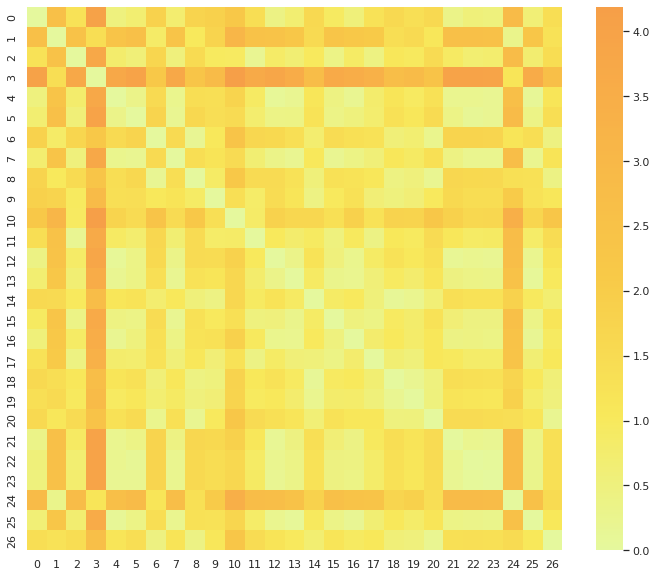

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,10)})
mask = np.triu(np.ones_like(matrix, dtype=bool))

sns.heatmap(matrix,cmap='Wistia',alpha=0.7)
plt.savefig('/media/haiyanwu/HDD2/xinyi_RanDishonesty/dishonesty_fMRI/1.GLM/f-brain/ddm-matrix.svg')